<a href="https://colab.research.google.com/github/pragathi916/SKIN-CANCER-DETECTION-USING-RESNET18/blob/main/SKIN_CANCER_DETECTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle torchvision scikit-learn matplotlib seaborn

import os, shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, roc_auc_score, confusion_matrix,
    precision_recall_curve, roc_curve, classification_report, f1_score
)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from google.colab import files


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.0 MB/s eta 0:00:00


In [2]:
files.upload()  # Upload kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip -q skin-cancer-mnist-ham10000.zip
!mkdir -p HAM10000_images
!cp HAM10000_images_part_1/* HAM10000_images/
!cp HAM10000_images_part_2/* HAM10000_images/


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.18G/5.20G [01:23<00:00, 283MB/s]
100% 5.20G/5.20G [01:23<00:00, 66.6MB/s]


In [3]:
df = pd.read_csv("HAM10000_metadata.csv")
df['label'] = df['dx'].apply(lambda x: 1 if x in ['mel', 'bkl', 'bcc', 'akiec'] else 0)

# Optional: Use smaller data for fast prototyping
df = df.groupby("label").apply(lambda x: x.sample(500, random_state=42)).reset_index(drop=True)

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, stratify=test_df['label'], random_state=42)


/tmp/ipython-input-3-3130957280.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("label").apply(lambda x: x.sample(500, random_state=42)).reset_index(drop=True)


In [4]:
class SkinLesionDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.df.loc[idx, 'image_id'] + '.jpg')
        image = Image.open(img_path).convert('RGB')
        label = self.df.loc[idx, 'label']
        if self.transform:
            image = self.transform(image)
        return image, label


In [5]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Faster training
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

def get_loaders(batch_size=32):
    return (
        DataLoader(SkinLesionDataset(train_df, "HAM10000_images", transform), batch_size=batch_size, shuffle=True, num_workers=2),
        DataLoader(SkinLesionDataset(val_df, "HAM10000_images", transform), batch_size=batch_size, num_workers=2),
        DataLoader(SkinLesionDataset(test_df, "HAM10000_images", transform), batch_size=batch_size, num_workers=2)
    )


In [6]:
def get_model():
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False  # Freeze backbone

    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(in_features, 1)
    )
    return model


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, optimizer, criterion, train_loader, val_loader, epochs=5):
    model.to(device)
    best_auc = 0
    history = {'val_auc': []}

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.float().to(device)
            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_labels, val_scores = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                outputs = model(images).squeeze()
                probs = torch.sigmoid(outputs)
                val_scores.extend(probs.cpu().numpy())
                val_labels.extend(labels.numpy())

        val_auc = roc_auc_score(val_labels, val_scores)
        print(f"Epoch {epoch+1}: AUC = {val_auc:.4f}")
        history['val_auc'].append(val_auc)

        if val_auc > best_auc:
            best_auc = val_auc
            torch.save(model.state_dict(), "best_model.pth")

    return history


In [8]:
def evaluate(model, test_loader):
    model.eval()
    preds, probs, labels = [], [], []

    with torch.no_grad():
        for images, label in test_loader:
            images = images.to(device)
            outputs = model(images).squeeze()
            prob = torch.sigmoid(outputs)
            pred = (prob > 0.5).float()

            probs.extend(prob.cpu().numpy())
            preds.extend(pred.cpu().numpy())
            labels.extend(label.numpy())

    print(classification_report(labels, preds, target_names=["Non-Cancer", "Cancer"]))
    sns.heatmap(confusion_matrix(labels, preds), annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix"); plt.show()


In [9]:
def predict_image(image_path, model):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    transform_img = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    img_tensor = transform_img(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor).squeeze()
        prob = torch.sigmoid(output).item()
        pred = "Cancer" if prob > 0.5 else "Non-Cancer"
    print(f"Prediction: {pred} (Probability: {prob:.2f})")
    plt.imshow(image)
    plt.title(pred)
    plt.axis('off')
    plt.show()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 184MB/s]


Epoch 1: AUC = 0.4756
Epoch 2: AUC = 0.4168
Epoch 3: AUC = 0.4544
Epoch 4: AUC = 0.4760
Epoch 5: AUC = 0.5228
              precision    recall  f1-score   support

  Non-Cancer       0.55      0.60      0.57        50
      Cancer       0.56      0.50      0.53        50

    accuracy                           0.55       100
   macro avg       0.55      0.55      0.55       100
weighted avg       0.55      0.55      0.55       100



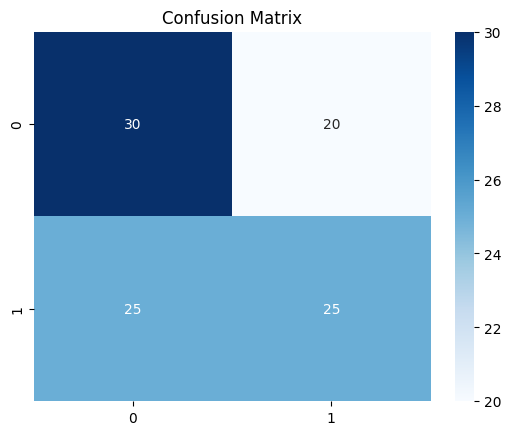

In [10]:
train_loader, val_loader, test_loader = get_loaders(batch_size=32)
model = get_model()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

history = train_model(model, optimizer, criterion, train_loader, val_loader, epochs=5)
model.load_state_dict(torch.load("best_model.pth"))
evaluate(model, test_loader)


Saving ISIC_0024308.jpg to ISIC_0024308.jpg
Prediction: Non-Cancer (Probability: 0.48)


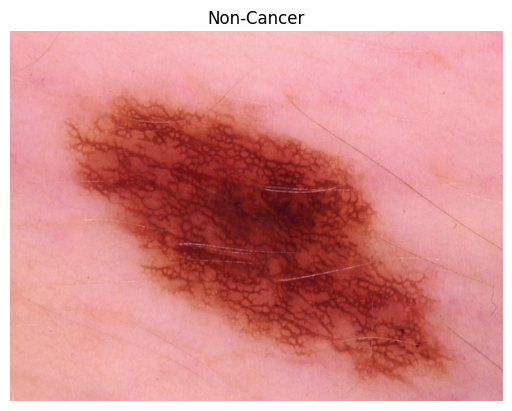

In [11]:
uploaded = files.upload()
img_path = list(uploaded.keys())[0]
predict_image(img_path, model)


In [12]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [13]:
import torch.nn.functional as F
import numpy as np
def get_loaders(batch_size=32):
    return (
        DataLoader(SkinLesionDataset(train_df, "HAM10000_images", transform), batch_size=batch_size, shuffle=True, num_workers=2),
        DataLoader(SkinLesionDataset(val_df, "HAM10000_images", transform), batch_size=batch_size, num_workers=2),
        DataLoader(SkinLesionDataset(test_df, "HAM10000_images", transform), batch_size=batch_size, num_workers=2)
    )

def get_all_preds():
    train_loader, val_loader, test_loader = get_loaders(batch_size=32)

    soft_outputs = []
    all_labels = []

    with torch.no_grad():
        for model in models_list:
            model.eval()
            all_probs = []
            for images, labels in test_loader:
                images = images.to(device)
                outputs = model(images)
                probs = F.softmax(outputs, dim=1)
                all_probs.append(probs.cpu())
            soft_outputs.append(torch.cat(all_probs, dim=0))

    soft_outputs = torch.stack(soft_outputs)  # [n_models, n_samples, 2]
    avg_probs = torch.mean(soft_outputs, dim=0)
    y_pred_soft = torch.argmax(avg_probs, dim=1).numpy()

    all_hard_preds = torch.argmax(soft_outputs, dim=2)  # [n_models, n_samples]
    y_pred_hard = torch.mode(all_hard_preds, dim=0).values.numpy()

    # Get true labels
    for _, labels in test_loader:
        all_labels.append(labels)
    y_true = torch.cat(all_labels, dim=0).numpy()

    return y_true, y_pred_soft, y_pred_hard


In [14]:
def get_model_resnet():
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Sequential(nn.Dropout(0.5), nn.Linear(model.fc.in_features, 1))
    return model

def get_model_vgg():
    model = models.vgg16(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, 1)
    return model

def get_model_mobilenet():
    model = models.mobilenet_v2(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)
    return model

def get_model_densenet():
    model = models.densenet121(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.classifier = nn.Linear(model.classifier.in_features, 1)
    return model

def get_model_efficientnet():
    model = models.efficientnet_b0(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)
    return model

def get_model_googlenet():
    model = models.googlenet(pretrained=True, aux_logits=False)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, 1)
    return model


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train_model(model, train_loader, val_loader, num_epochs=5, lr=1e-4, model_name="model.pth"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        val_acc = evaluate_model(model, val_loader, device)

        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), model_name)
            print(f"✅ Saved Best Model: {model_name} (Val Acc: {val_acc:.4f})")

def evaluate_model(model, val_loader, device):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.sigmoid(outputs).squeeze() > 0.5
            correct += (preds.int() == labels).sum().item()
            total += labels.size(0)

    return correct / total


In [16]:
from torchvision.models import (
    ResNet18_Weights, VGG16_Weights, MobileNet_V2_Weights,
    DenseNet121_Weights, EfficientNet_B0_Weights, GoogLeNet_Weights
)

In [17]:
def get_model_googlenet():
    model = models.googlenet(weights=GoogLeNet_Weights.DEFAULT)  # Default is aux_logits=True
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, 1)

    # Disable auxiliary classifiers by setting them to identity (optional)
    model.aux1 = nn.Identity()
    model.aux2 = nn.Identity()
    return model


In [18]:
train_model(get_model_resnet(), train_loader, val_loader, num_epochs=5, model_name="resnet.pth")
train_model(get_model_vgg(), train_loader, val_loader, num_epochs=5, model_name="vgg.pth")
train_model(get_model_mobilenet(), train_loader, val_loader, num_epochs=5, model_name="mobilenet.pth")
train_model(get_model_densenet(), train_loader, val_loader, num_epochs=5, model_name="densenet.pth")
train_model(get_model_efficientnet(), train_loader, val_loader, num_epochs=5, model_name="efficientnet.pth")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/5: 100%|██████████| 25/25 [00:04<00:00,  5.30it/s]


Epoch 1, Loss: 0.8117, Val Acc: 0.4100
✅ Saved Best Model: resnet.pth (Val Acc: 0.4100)


Epoch 2/5: 100%|██████████| 25/25 [00:07<00:00,  3.48it/s]


Epoch 2, Loss: 0.8053, Val Acc: 0.5000
✅ Saved Best Model: resnet.pth (Val Acc: 0.5000)


Epoch 3/5: 100%|██████████| 25/25 [00:04<00:00,  5.33it/s]


Epoch 3, Loss: 0.8003, Val Acc: 0.5300
✅ Saved Best Model: resnet.pth (Val Acc: 0.5300)


Epoch 4/5: 100%|██████████| 25/25 [00:05<00:00,  4.56it/s]


Epoch 4, Loss: 0.7517, Val Acc: 0.5400
✅ Saved Best Model: resnet.pth (Val Acc: 0.5400)


Epoch 5/5: 100%|██████████| 25/25 [00:05<00:00,  4.77it/s]


Epoch 5, Loss: 0.7520, Val Acc: 0.5600
✅ Saved Best Model: resnet.pth (Val Acc: 0.5600)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 179MB/s]
Epoch 1/5: 100%|██████████| 25/25 [00:07<00:00,  3.31it/s]


Epoch 1, Loss: 0.6716, Val Acc: 0.6200
✅ Saved Best Model: vgg.pth (Val Acc: 0.6200)


Epoch 2/5: 100%|██████████| 25/25 [00:08<00:00,  2.86it/s]


Epoch 2, Loss: 0.6262, Val Acc: 0.7100
✅ Saved Best Model: vgg.pth (Val Acc: 0.7100)


Epoch 3/5: 100%|██████████| 25/25 [00:05<00:00,  4.60it/s]


Epoch 3, Loss: 0.5916, Val Acc: 0.7300
✅ Saved Best Model: vgg.pth (Val Acc: 0.7300)


Epoch 4/5: 100%|██████████| 25/25 [00:05<00:00,  4.49it/s]


Epoch 4, Loss: 0.5742, Val Acc: 0.7300


Epoch 5/5: 100%|██████████| 25/25 [00:05<00:00,  4.23it/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


Epoch 5, Loss: 0.5542, Val Acc: 0.7300


100%|██████████| 13.6M/13.6M [00:00<00:00, 115MB/s] 
Epoch 1/5: 100%|██████████| 25/25 [00:05<00:00,  4.59it/s]


Epoch 1, Loss: 0.7259, Val Acc: 0.5300
✅ Saved Best Model: mobilenet.pth (Val Acc: 0.5300)


Epoch 2/5: 100%|██████████| 25/25 [00:05<00:00,  4.56it/s]


Epoch 2, Loss: 0.6793, Val Acc: 0.5800
✅ Saved Best Model: mobilenet.pth (Val Acc: 0.5800)


Epoch 3/5: 100%|██████████| 25/25 [00:05<00:00,  4.26it/s]


Epoch 3, Loss: 0.6364, Val Acc: 0.6900
✅ Saved Best Model: mobilenet.pth (Val Acc: 0.6900)


Epoch 4/5: 100%|██████████| 25/25 [00:05<00:00,  4.62it/s]


Epoch 4, Loss: 0.6033, Val Acc: 0.7100
✅ Saved Best Model: mobilenet.pth (Val Acc: 0.7100)


Epoch 5/5: 100%|██████████| 25/25 [00:07<00:00,  3.56it/s]


Epoch 5, Loss: 0.5840, Val Acc: 0.7300
✅ Saved Best Model: mobilenet.pth (Val Acc: 0.7300)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 145MB/s]
Epoch 1/5: 100%|██████████| 25/25 [00:05<00:00,  4.91it/s]


Epoch 1, Loss: 0.7148, Val Acc: 0.6600
✅ Saved Best Model: densenet.pth (Val Acc: 0.6600)


Epoch 2/5: 100%|██████████| 25/25 [00:07<00:00,  3.36it/s]


Epoch 2, Loss: 0.6884, Val Acc: 0.5700


Epoch 3/5: 100%|██████████| 25/25 [00:05<00:00,  4.33it/s]


Epoch 3, Loss: 0.6542, Val Acc: 0.5400


Epoch 4/5: 100%|██████████| 25/25 [00:06<00:00,  3.61it/s]


Epoch 4, Loss: 0.6440, Val Acc: 0.5800


Epoch 5/5: 100%|██████████| 25/25 [00:05<00:00,  4.50it/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


Epoch 5, Loss: 0.6282, Val Acc: 0.6100


100%|██████████| 20.5M/20.5M [00:00<00:00, 77.9MB/s]
Epoch 1/5: 100%|██████████| 25/25 [00:07<00:00,  3.25it/s]


Epoch 1, Loss: 0.7004, Val Acc: 0.5700
✅ Saved Best Model: efficientnet.pth (Val Acc: 0.5700)


Epoch 2/5: 100%|██████████| 25/25 [00:04<00:00,  5.21it/s]


Epoch 2, Loss: 0.6750, Val Acc: 0.6600
✅ Saved Best Model: efficientnet.pth (Val Acc: 0.6600)


Epoch 3/5: 100%|██████████| 25/25 [00:07<00:00,  3.46it/s]


Epoch 3, Loss: 0.6527, Val Acc: 0.7000
✅ Saved Best Model: efficientnet.pth (Val Acc: 0.7000)


Epoch 4/5: 100%|██████████| 25/25 [00:04<00:00,  5.24it/s]


Epoch 4, Loss: 0.6289, Val Acc: 0.7100
✅ Saved Best Model: efficientnet.pth (Val Acc: 0.7100)


Epoch 5/5: 100%|██████████| 25/25 [00:06<00:00,  4.09it/s]


Epoch 5, Loss: 0.6096, Val Acc: 0.7200
✅ Saved Best Model: efficientnet.pth (Val Acc: 0.7200)


In [19]:
train_model(get_model_googlenet(), train_loader, val_loader, num_epochs=5, model_name="googlenet.pth")

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 180MB/s]
Epoch 1/5: 100%|██████████| 25/25 [00:04<00:00,  5.20it/s]


Epoch 1, Loss: 0.7083, Val Acc: 0.5300
✅ Saved Best Model: googlenet.pth (Val Acc: 0.5300)


Epoch 2/5: 100%|██████████| 25/25 [00:05<00:00,  4.34it/s]


Epoch 2, Loss: 0.6756, Val Acc: 0.6600
✅ Saved Best Model: googlenet.pth (Val Acc: 0.6600)


Epoch 3/5: 100%|██████████| 25/25 [00:04<00:00,  5.05it/s]


Epoch 3, Loss: 0.6593, Val Acc: 0.6800
✅ Saved Best Model: googlenet.pth (Val Acc: 0.6800)


Epoch 4/5: 100%|██████████| 25/25 [00:06<00:00,  3.95it/s]


Epoch 4, Loss: 0.6484, Val Acc: 0.7400
✅ Saved Best Model: googlenet.pth (Val Acc: 0.7400)


Epoch 5/5: 100%|██████████| 25/25 [00:06<00:00,  4.03it/s]


Epoch 5, Loss: 0.6377, Val Acc: 0.7800
✅ Saved Best Model: googlenet.pth (Val Acc: 0.7800)


In [20]:
models_list = [
    get_model_resnet(),
    get_model_vgg(),
    get_model_mobilenet(),
    get_model_densenet(),
    get_model_efficientnet(),
    get_model_googlenet()
]

In [25]:
import torch
import torch.nn.functional as F

# ================== LOAD SAVED MODEL ==================
def load_model(get_model_func, path):
    model = get_model_func()
    model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
    model.eval()
    return model


def get_all_preds():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load and send all models to device
    models_list = [
        load_model(get_model_resnet, 'resnet.pth').to(device),
        load_model(get_model_vgg, 'vgg.pth').to(device),
        load_model(get_model_mobilenet, 'mobilenet.pth').to(device),
        load_model(get_model_densenet, 'densenet.pth').to(device),
        load_model(get_model_efficientnet, 'efficientnet.pth').to(device),
        load_model(get_model_googlenet, 'googlenet.pth').to(device),
    ]

    for model in models_list:
        model.eval()

    all_true = []
    all_soft_preds = []
    all_hard_preds = []

    with torch.no_grad():
        for images, labels in test_loader:  # Make sure test_loader is defined
            images = images.to(device)
            labels = labels.to(device)

            preds = []

            for model in models_list:
                outputs = model(images)
                prob = torch.sigmoid(outputs).squeeze()
                preds.append(prob)

            # Stack predictions: shape = (num_models, batch_size)
            stacked_preds = torch.stack(preds)

            # Soft Voting: average probabilities
            avg_probs = torch.mean(stacked_preds, dim=0)
            soft_preds = (avg_probs > 0.5).int()

            # Hard Voting: majority vote
            hard_votes = (stacked_preds > 0.5).int()
            hard_preds = (torch.sum(hard_votes, dim=0) > (len(models_list) // 2)).int()

            all_true.extend(labels.int().cpu().numpy())
            all_soft_preds.extend(soft_preds.cpu().numpy())
            all_hard_preds.extend(hard_preds.cpu().numpy())

    return all_true, all_soft_preds, all_hard_preds



--- Soft Voting ---
Accuracy: 0.78
F1 Score: 0.78
Precision: 0.78
Confusion Matrix:
 [[39 11]
 [11 39]]

--- Hard Voting ---
Accuracy: 0.74
F1 Score: 0.723404255319149
Precision: 0.7727272727272727
Confusion Matrix:
 [[40 10]
 [16 34]]


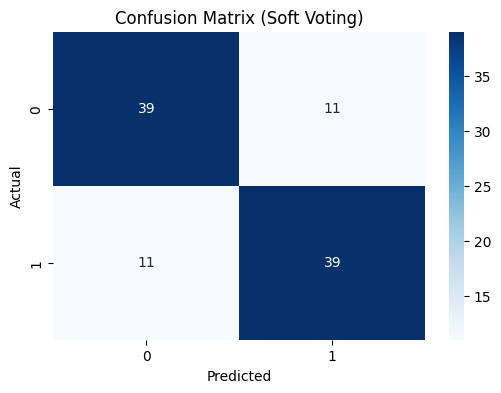

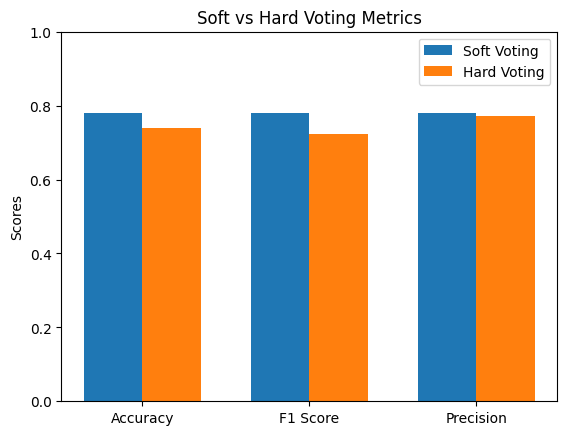

In [26]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate(y_true, y_pred, label):
    print(f"\n--- {label} Voting ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    return {
        'label': label,
        'accuracy': accuracy_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred)
    }

y_true, y_pred_soft, y_pred_hard = get_all_preds()
metrics_soft = evaluate(y_true, y_pred_soft, "Soft")
metrics_hard = evaluate(y_true, y_pred_hard, "Hard")

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_true, y_pred_soft), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Soft Voting)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot metrics
labels = ["Accuracy", "F1 Score", "Precision"]
soft_vals = [metrics_soft['accuracy'], metrics_soft['f1'], metrics_soft['precision']]
hard_vals = [metrics_hard['accuracy'], metrics_hard['f1'], metrics_hard['precision']]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
ax.bar(x - width/2, soft_vals, width, label='Soft Voting')
ax.bar(x + width/2, hard_vals, width, label='Hard Voting')

ax.set_ylabel('Scores')
ax.set_title('Soft vs Hard Voting Metrics')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.ylim([0, 1])
plt.show()


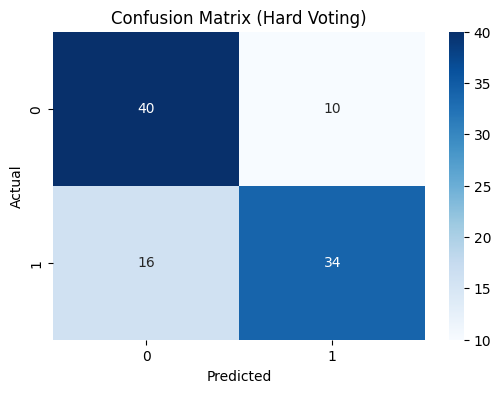

In [27]:
# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_true, y_pred_hard), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Hard Voting)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [28]:
def print_classification_results(y_true, y_pred):
    for i, (true, pred) in enumerate(zip(y_true, y_pred)):
        true_label = "Cancer" if true == 1 else "Non-Cancer"
        pred_label = "Cancer" if pred == 1 else "Non-Cancer"
        print(f"Image {i+1}: True Label = {true_label}, Predicted = {pred_label}")


In [29]:
print_classification_results(y_true, y_pred_soft)  # or y_pred_hard

Image 1: True Label = Cancer, Predicted = Cancer
Image 2: True Label = Non-Cancer, Predicted = Non-Cancer
Image 3: True Label = Non-Cancer, Predicted = Non-Cancer
Image 4: True Label = Cancer, Predicted = Cancer
Image 5: True Label = Cancer, Predicted = Cancer
Image 6: True Label = Cancer, Predicted = Cancer
Image 7: True Label = Cancer, Predicted = Cancer
Image 8: True Label = Cancer, Predicted = Cancer
Image 9: True Label = Non-Cancer, Predicted = Non-Cancer
Image 10: True Label = Cancer, Predicted = Cancer
Image 11: True Label = Non-Cancer, Predicted = Non-Cancer
Image 12: True Label = Cancer, Predicted = Cancer
Image 13: True Label = Cancer, Predicted = Non-Cancer
Image 14: True Label = Cancer, Predicted = Cancer
Image 15: True Label = Cancer, Predicted = Cancer
Image 16: True Label = Non-Cancer, Predicted = Non-Cancer
Image 17: True Label = Non-Cancer, Predicted = Non-Cancer
Image 18: True Label = Non-Cancer, Predicted = Non-Cancer
Image 19: True Label = Cancer, Predicted = Non-Ca

In [30]:
print_classification_results(y_true, y_pred_hard)

Image 1: True Label = Cancer, Predicted = Cancer
Image 2: True Label = Non-Cancer, Predicted = Non-Cancer
Image 3: True Label = Non-Cancer, Predicted = Non-Cancer
Image 4: True Label = Cancer, Predicted = Cancer
Image 5: True Label = Cancer, Predicted = Cancer
Image 6: True Label = Cancer, Predicted = Cancer
Image 7: True Label = Cancer, Predicted = Non-Cancer
Image 8: True Label = Cancer, Predicted = Cancer
Image 9: True Label = Non-Cancer, Predicted = Non-Cancer
Image 10: True Label = Cancer, Predicted = Cancer
Image 11: True Label = Non-Cancer, Predicted = Non-Cancer
Image 12: True Label = Cancer, Predicted = Cancer
Image 13: True Label = Cancer, Predicted = Non-Cancer
Image 14: True Label = Cancer, Predicted = Cancer
Image 15: True Label = Cancer, Predicted = Cancer
Image 16: True Label = Non-Cancer, Predicted = Non-Cancer
Image 17: True Label = Non-Cancer, Predicted = Non-Cancer
Image 18: True Label = Non-Cancer, Predicted = Non-Cancer
Image 19: True Label = Cancer, Predicted = No

In [31]:
def show_sample_predictions(models_list, test_loader, device, y_true, y_pred):
    import matplotlib.pyplot as plt

    # Load a few sample images
    test_iter = iter(test_loader)
    images, labels = next(test_iter)

    images = images.to(device)

    fig, axes = plt.subplots(1, 5, figsize=(15, 5))

    for idx in range(5):
        img = images[idx].cpu().permute(1, 2, 0).numpy()
        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(
            f"True: {'Cancer' if y_true[idx]==1 else 'Non-Cancer'}\n"
            f"Pred: {'Cancer' if y_pred[idx]==1 else 'Non-Cancer'}"
        )
    plt.tight_layout()
    plt.show()


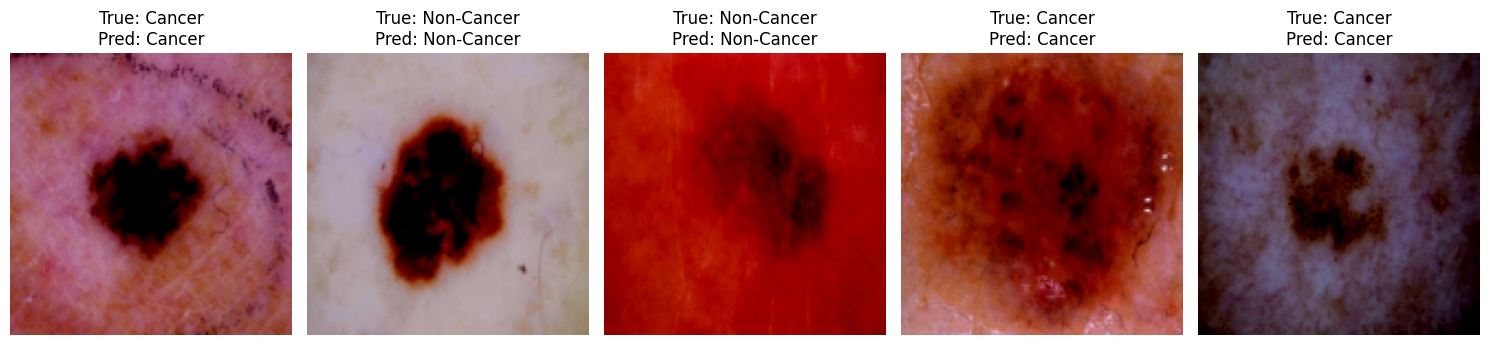

In [32]:
show_sample_predictions(models_list, test_loader, device, y_true, y_pred_soft)


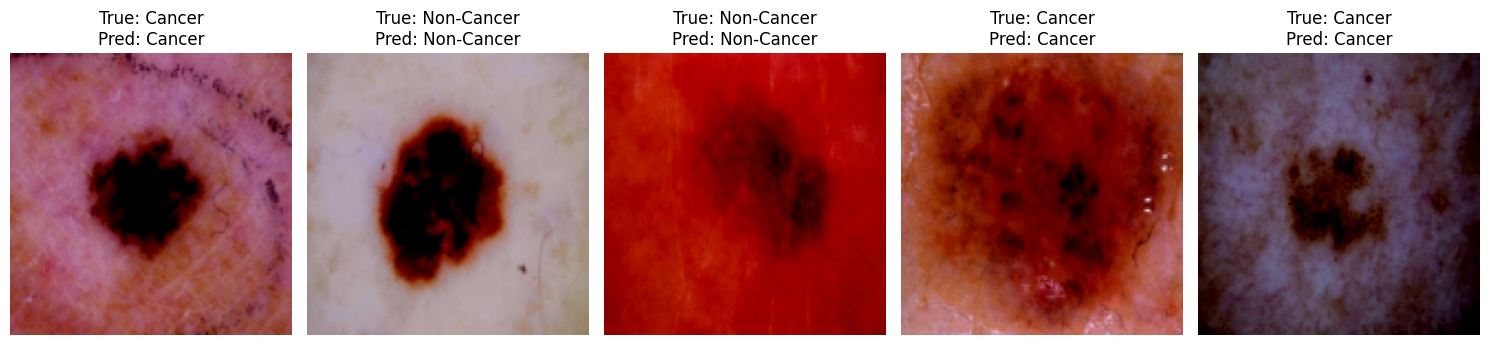

In [33]:
show_sample_predictions(models_list, test_loader, device, y_true, y_pred_hard)


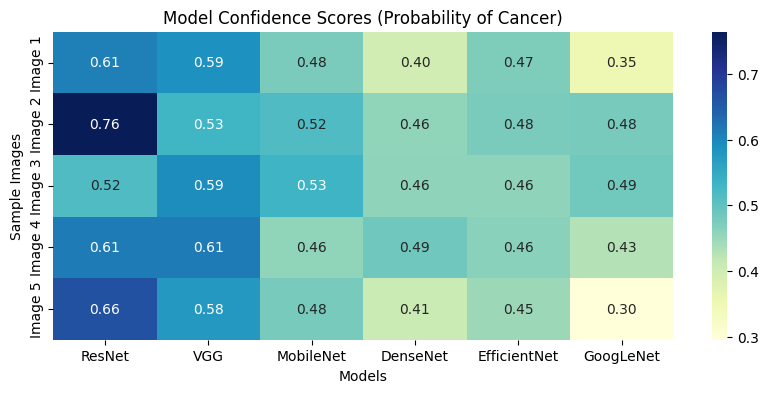

In [37]:
# ================== HEATMAP OF MODEL CONFIDENCES ==================
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Names of the models in the order they were loaded
model_names = ["ResNet", "VGG", "MobileNet", "DenseNet", "EfficientNet", "GoogLeNet"]

# Select a few samples from the test set
num_samples = 5
sample_images, sample_labels = next(iter(test_loader))
sample_images = sample_images[:num_samples].to(device)

# Ensure all models are in eval mode
for model in models_list:
    model.eval()
# Ensure all models are in eval mode and on the same device
for i, model in enumerate(models_list):
    model = model.to(device)
    model.eval()
    models_list[i] = model


# Get predictions from each model
prob_matrix = []
for model in models_list:
    with torch.no_grad():
        logits = model(sample_images).squeeze()
        probs = torch.sigmoid(logits).cpu().numpy()
        prob_matrix.append(probs)

# Transpose to get shape: (num_samples, num_models)
import numpy as np
prob_matrix = np.array(prob_matrix).T  # shape = (5, 6)

# Create DataFrame for heatmap
import pandas as pd
df_heat = pd.DataFrame(prob_matrix, columns=model_names)
df_heat.index = [f"Image {i+1}" for i in range(num_samples)]

# Plot the heatmap
plt.figure(figsize=(10, 4))
sns.heatmap(df_heat, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Model Confidence Scores (Probability of Cancer)")
plt.ylabel("Sample Images")
plt.xlabel("Models")
plt.show()
